In [22]:
import essentia
import numpy as np
from essentia.standard import *
import matplotlib.pyplot as plt
from matplotlib import cm

class AudioExtractor:

    def __init__(self,loop):
        self.loop = loop
        self.chopList = []
        self.fs = 44100
        self.w_onset = 'hann'
        self.mfccs = []
        self.w_mfcc = 'blackmanharris62'

    def __call__(self):
        return self.chopList

    def get_onsets(self):
        od = OnsetDetection(method='hfc')

        w = Windowing(type=self.w_onset)
        fft = FFT()  # this gives us a complex FFT
        c2p = CartesianToPolar()  # and this turns it into a pair (magnitude, phase)
        pool = essentia.Pool()

        # Computing onset detection functions.
        for frame in FrameGenerator(self.loop, frameSize=1024, hopSize=512):
            mag, phase, = c2p(fft(w(frame)))
            pool.add('features.hfc', od(mag, phase))

        onsets = Onsets()
        onsets_hfc_seconds = onsets(essentia.array([pool['features.hfc']]), [1])

        onsets_hfc_samples = onsets_hfc_seconds * self.fs #retun
        return onsets_hfc_samples, onsets_hfc_seconds


    def get_slices(self,onsets_hfc):
        onsets_hfc = onsets_hfc[0]  # onset stamps in samples
        for onset in range(len(onsets_hfc) - 1):
            self.chopList.append(self.loop[int(onsets_hfc[onset]):int((onsets_hfc[onset + 1]))])


    def extract_mfcc(self,slice):
        w = Windowing(type=self.w_mfcc)
        spectrum = Spectrum()
        mfcc = MFCC()
        for frame in FrameGenerator(slice, frameSize=2048, hopSize=1024):
            mfcc_bands, mfcc_coeffs = mfcc(spectrum(w(frame)))
            self.mfccs.append(mfcc_coeffs)
        self.mfccs = essentia.array(self.mfccs).T
        self.mfccs = np.squeeze(np.asarray(self.mfccs))
        row_sums = self.mfccs.sum(axis=1)
        self.mfccs = self.mfccs / row_sums[:, np.newaxis]
        print(self.mfccs.shape[1])

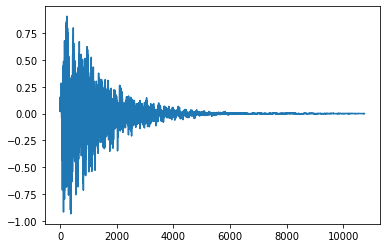

12


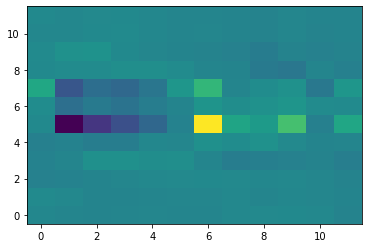

In [23]:
loop = MonoLoader(filename='../loops/audio3.wav')()
loop1 = AudioExtractor(loop)
onsets_hfc = loop1.get_onsets()
loop1.get_slices(onsets_hfc)

# chopList contain the list of slices, separately
slice1 = loop1.chopList[2] #first slice
plt.plot(slice1)
plt.show()

loop1.extract_mfcc(slice1)

plt.imshow(loop1.mfccs[1:,:], aspect='auto', origin='lower', interpolation='none')
plt.show()
